In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

Load the text extraction data (assuming multiple cluster files) and the video engagement data.

In [3]:
# Specify the folder containing the cluster files
cluster_folder = 'text_clusters'  # Replace with the actual folder path

# List all CSV files in the folder
cluster_files = [os.path.join(cluster_folder, f) for f in os.listdir(cluster_folder) if f.endswith('.csv')]

# Print the list of files to verify
print("Cluster Files Found:")
print(cluster_files)

Cluster Files Found:
['text_clusters\\df_cluster_0.csv', 'text_clusters\\df_cluster_1.csv', 'text_clusters\\df_cluster_2.csv', 'text_clusters\\df_cluster_3.csv', 'text_clusters\\df_cluster_4.csv', 'text_clusters\\df_cluster_5.csv']


In [4]:
# Combine all cluster data into one DataFrame
text_data = pd.concat([pd.read_csv(file) for file in cluster_files], ignore_index=True)

# Load video engagement data
video_data = pd.read_csv('results_count_with_error.csv')

In [5]:
# Display the first few rows of both datasets
print("\nText Extraction Data:")
print(text_data.head())

print("\nVideo Engagement Data:")
print(video_data.head())


Text Extraction Data:
      Video ID                               text_cleaned  cluster  \
0  TeMYei9-L3I                     HOW TO DRINK RED HORSE        0   
1  7YUatj_Uq6c           TOP 10 PLACES TO SEE PHILIPPINES        0   
2  Q7teS12VJfg                              ANGELICA HALE        0   
3  QG61j-coCgM  THE MIRACLE OF T16 ICONIC ESPORTS MOMENTS        0   
4  z9K8LE9lgqA                DAY 1 HEL DAY 2 THE PEOPLE.        0   

   x0_Bert-CLS  x1_Bert-CLS  
0     2.089855    -1.174470  
1     1.764231    -1.594547  
2     1.416814    -1.715946  
3     1.863088    -2.554374  
4     1.518131    -0.203527  

Video Engagement Data:
      Video ID  View Count  Like Count  Comment Count
0  lZXDClzL8m8     4885860       75940           3507
1  XsWKvutlu8I     3545247       55237           1656
2  stMSVi5wI8k     3824080       67281           2274
3  b7HQU_--Qdw      596295       10123            831
4  zDwuJgLNJbc     4322068       74383           4734


In [6]:
# Merge datasets on 'Video ID'
merged_data = pd.merge(text_data, video_data, on='Video ID', how='inner')

# Check the merged dataset
print("\nMerged Dataset:")
print(merged_data.head())


Merged Dataset:
      Video ID                               text_cleaned  cluster  \
0  TeMYei9-L3I                     HOW TO DRINK RED HORSE        0   
1  7YUatj_Uq6c           TOP 10 PLACES TO SEE PHILIPPINES        0   
2  Q7teS12VJfg                              ANGELICA HALE        0   
3  QG61j-coCgM  THE MIRACLE OF T16 ICONIC ESPORTS MOMENTS        0   
4  z9K8LE9lgqA                DAY 1 HEL DAY 2 THE PEOPLE.        0   

   x0_Bert-CLS  x1_Bert-CLS  View Count  Like Count  Comment Count  
0     2.089855    -1.174470        3864         296             95  
1     1.764231    -1.594547       27166        1415             43  
2     1.416814    -1.715946       16090         613             58  
3     1.863088    -2.554374     1825759       16723           1736  
4     1.518131    -0.203527       13262         489             52  


In [7]:
# Group by cluster and calculate total and average engagement metrics
cluster_summary = merged_data.groupby('cluster').agg(
    Total_Views=('View Count', 'sum'),
    Avg_Views=('View Count', 'mean'),
    Total_Likes=('Like Count', 'sum'),
    Avg_Likes=('Like Count', 'mean'),
    Total_Comments=('Comment Count', 'sum'),
    Avg_Comments=('Comment Count', 'mean')
).reset_index()

# Display the summary
print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
   cluster  Total_Views     Avg_Views  Total_Likes    Avg_Likes  \
0        0    229628931  3.005614e+05      5854608  7663.099476   
1        1     65872706  1.441416e+05      1969263  4309.109409   
2        2     43198709  1.380150e+05      1169457  3736.284345   
3        3    470869428  1.401397e+06      2955638  8796.541667   
4        4     16310115  1.019382e+05       393989  2462.431250   
5        5     75456219  1.840396e+05      1542189  3761.436585   

   Total_Comments  Avg_Comments  
0          302856    396.408377  
1          205541    449.761488  
2           88158    281.654952  
3          172010    511.934524  
4           33976    212.350000  
5          128444    313.278049  


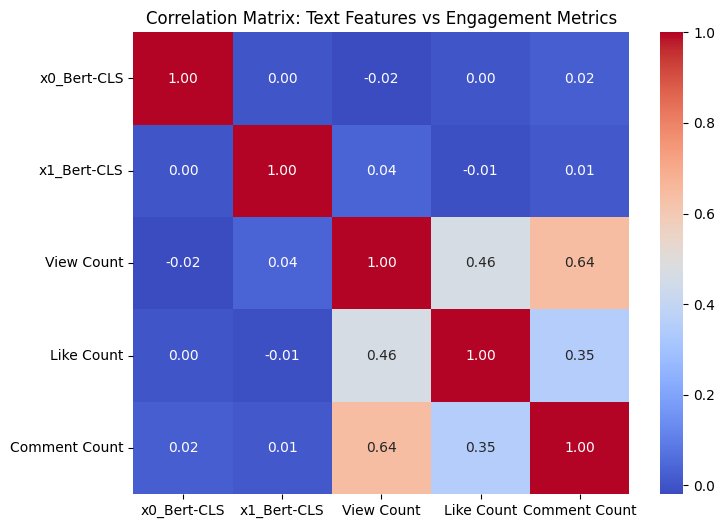

In [8]:
# Correlation analysis
correlation_data = merged_data[['x0_Bert-CLS', 'x1_Bert-CLS', 'View Count', 'Like Count', 'Comment Count']]
correlation_matrix = correlation_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Text Features vs Engagement Metrics')
plt.show()


Cluster 0 Correlation Matrix:
               x0_Bert-CLS  x1_Bert-CLS  View Count  Like Count  Comment Count
x0_Bert-CLS       1.000000    -0.040761   -0.060908   -0.061359       0.007135
x1_Bert-CLS      -0.040761     1.000000   -0.001368    0.014038       0.020743
View Count       -0.060908    -0.001368    1.000000    0.930827       0.531218
Like Count       -0.061359     0.014038    0.930827    1.000000       0.299328
Comment Count     0.007135     0.020743    0.531218    0.299328       1.000000


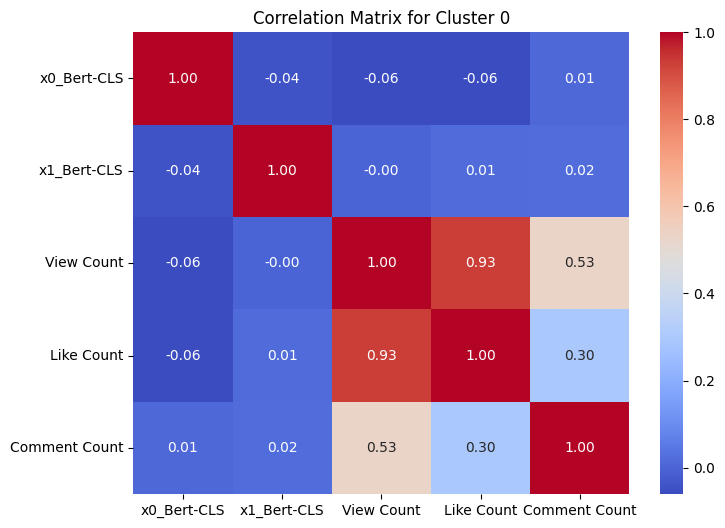


Cluster 1 Correlation Matrix:
               x0_Bert-CLS  x1_Bert-CLS  View Count  Like Count  Comment Count
x0_Bert-CLS       1.000000    -0.401625    0.044939    0.062860       0.038696
x1_Bert-CLS      -0.401625     1.000000   -0.103926   -0.099204      -0.068007
View Count        0.044939    -0.103926    1.000000    0.886612       0.715719
Like Count        0.062860    -0.099204    0.886612    1.000000       0.847091
Comment Count     0.038696    -0.068007    0.715719    0.847091       1.000000


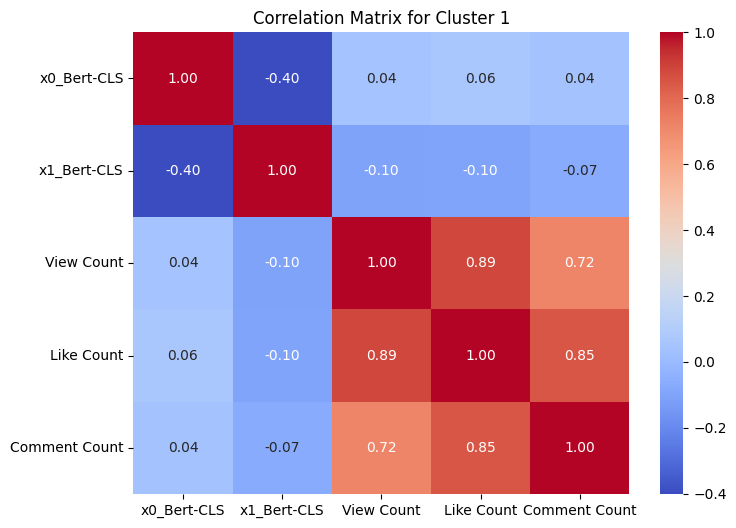


Cluster 2 Correlation Matrix:
               x0_Bert-CLS  x1_Bert-CLS  View Count  Like Count  Comment Count
x0_Bert-CLS            NaN          NaN         NaN         NaN            NaN
x1_Bert-CLS            NaN     1.000000    0.019926   -0.036728      -0.063172
View Count             NaN     0.019926    1.000000    0.835726       0.657325
Like Count             NaN    -0.036728    0.835726    1.000000       0.863545
Comment Count          NaN    -0.063172    0.657325    0.863545       1.000000


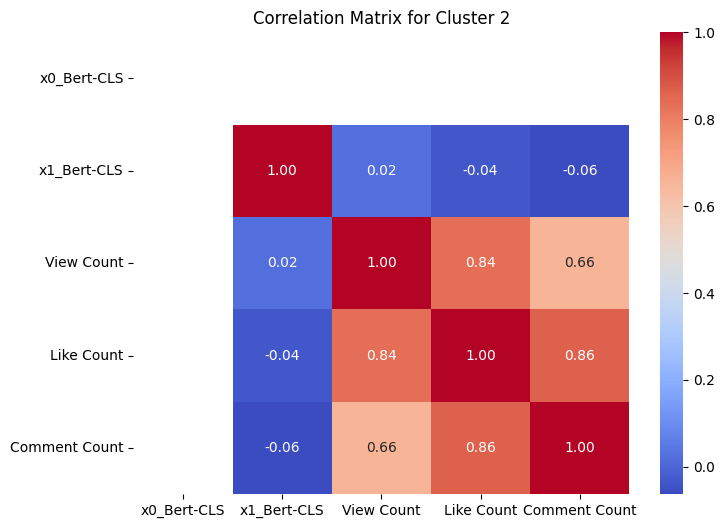


Cluster 3 Correlation Matrix:
               x0_Bert-CLS  x1_Bert-CLS  View Count  Like Count  Comment Count
x0_Bert-CLS       1.000000     0.065873   -0.101183   -0.119833      -0.107902
x1_Bert-CLS       0.065873     1.000000    0.038810    0.077701       0.038821
View Count       -0.101183     0.038810    1.000000    0.774030       0.898338
Like Count       -0.119833     0.077701    0.774030    1.000000       0.842712
Comment Count    -0.107902     0.038821    0.898338    0.842712       1.000000


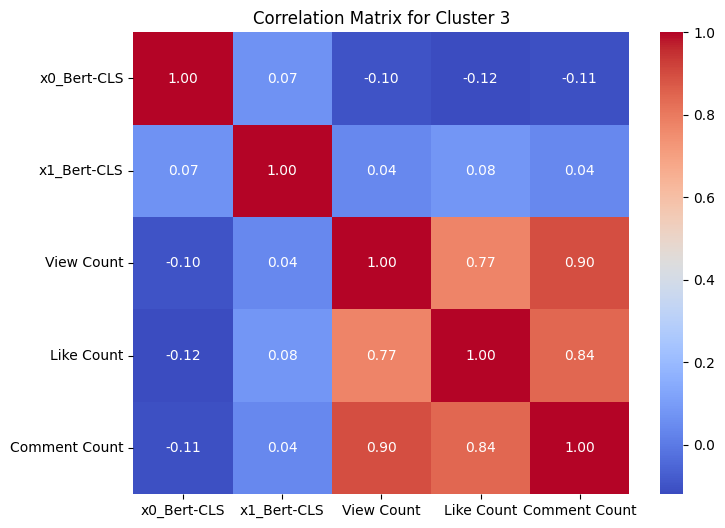


Cluster 4 Correlation Matrix:
               x0_Bert-CLS  x1_Bert-CLS  View Count  Like Count  Comment Count
x0_Bert-CLS       1.000000    -0.556562   -0.044673   -0.074944      -0.124084
x1_Bert-CLS      -0.556562     1.000000   -0.003256    0.012883       0.121698
View Count       -0.044673    -0.003256    1.000000    0.905756       0.666100
Like Count       -0.074944     0.012883    0.905756    1.000000       0.876113
Comment Count    -0.124084     0.121698    0.666100    0.876113       1.000000


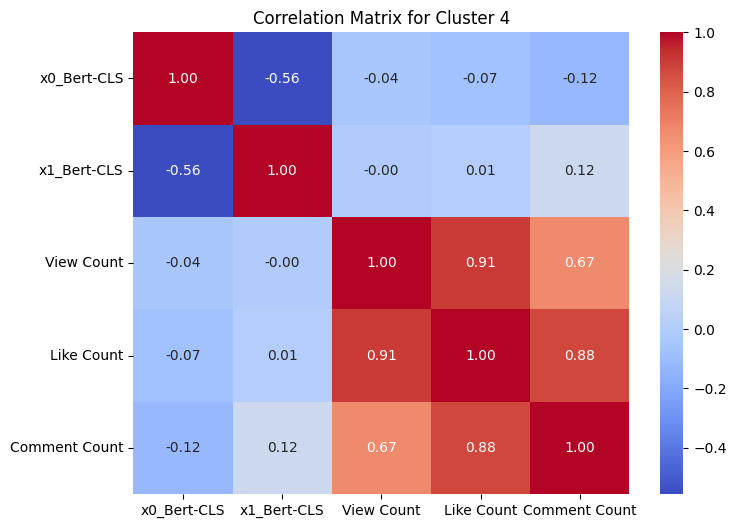


Cluster 5 Correlation Matrix:
               x0_Bert-CLS  x1_Bert-CLS  View Count  Like Count  Comment Count
x0_Bert-CLS       1.000000    -0.055530   -0.013383   -0.020872      -0.029977
x1_Bert-CLS      -0.055530     1.000000   -0.130291   -0.146590      -0.165330
View Count       -0.013383    -0.130291    1.000000    0.934075       0.781094
Like Count       -0.020872    -0.146590    0.934075    1.000000       0.843284
Comment Count    -0.029977    -0.165330    0.781094    0.843284       1.000000


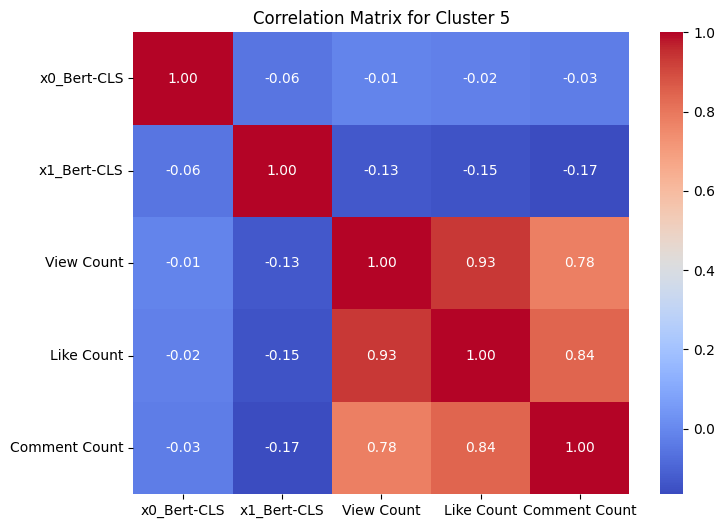

In [9]:
# Group the data by 'cluster'
grouped = merged_data.groupby('cluster')

# Iterate through each cluster and compute the correlation matrix
for cluster, group_data in grouped:
    print(f"\nCluster {cluster} Correlation Matrix:")
    
    # Select relevant columns for correlation analysis
    correlation_data = group_data[['x0_Bert-CLS', 'x1_Bert-CLS', 'View Count', 'Like Count', 'Comment Count']]
    
    # Compute the correlation matrix
    correlation_matrix = correlation_data.corr()
    print(correlation_matrix)
    
    # Visualize the correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Matrix for Cluster {cluster}')
    plt.show()

In [11]:
# Top clusters by total views
top_clusters_by_views = cluster_summary.sort_values(by='Total_Views', ascending=False).head()
print("\nTop Clusters by Total Views:")
print(top_clusters_by_views)


Top Clusters by Total Views:
   cluster  Total_Views     Avg_Views  Total_Likes    Avg_Likes  \
3        3    470869428  1.401397e+06      2955638  8796.541667   
0        0    229628931  3.005614e+05      5854608  7663.099476   
5        5     75456219  1.840396e+05      1542189  3761.436585   
1        1     65872706  1.441416e+05      1969263  4309.109409   
2        2     43198709  1.380150e+05      1169457  3736.284345   

   Total_Comments  Avg_Comments  
3          172010    511.934524  
0          302856    396.408377  
5          128444    313.278049  
1          205541    449.761488  
2           88158    281.654952  


In [13]:
# Find top clusters by total likes
top_clusters_by_likes = cluster_summary.sort_values(by='Total_Likes', ascending=False).head()
print("\nTop Clusters by Total Likes:")
print(top_clusters_by_likes)


Top Clusters by Total Likes:
   cluster  Total_Views     Avg_Views  Total_Likes    Avg_Likes  \
0        0    229628931  3.005614e+05      5854608  7663.099476   
3        3    470869428  1.401397e+06      2955638  8796.541667   
1        1     65872706  1.441416e+05      1969263  4309.109409   
5        5     75456219  1.840396e+05      1542189  3761.436585   
2        2     43198709  1.380150e+05      1169457  3736.284345   

   Total_Comments  Avg_Comments  
0          302856    396.408377  
3          172010    511.934524  
1          205541    449.761488  
5          128444    313.278049  
2           88158    281.654952  


In [14]:
# Find top clusters by total comments
top_clusters_by_comments = cluster_summary.sort_values(by='Total_Comments', ascending=False).head()
print("\nTop Clusters by Total Comments:")
print(top_clusters_by_comments)


Top Clusters by Total Comments:
   cluster  Total_Views     Avg_Views  Total_Likes    Avg_Likes  \
0        0    229628931  3.005614e+05      5854608  7663.099476   
1        1     65872706  1.441416e+05      1969263  4309.109409   
3        3    470869428  1.401397e+06      2955638  8796.541667   
5        5     75456219  1.840396e+05      1542189  3761.436585   
2        2     43198709  1.380150e+05      1169457  3736.284345   

   Total_Comments  Avg_Comments  
0          302856    396.408377  
1          205541    449.761488  
3          172010    511.934524  
5          128444    313.278049  
2           88158    281.654952  


In [16]:
# Add a new column for the combined total of views, likes, and comments
cluster_summary['Combined_Total'] = (
    cluster_summary['Total_Views'] +
    cluster_summary['Total_Likes'] +
    cluster_summary['Total_Comments']
)

# Find top clusters by combined total
top_clusters_by_combined = cluster_summary.sort_values(by='Combined_Total', ascending=False).head()
print("\nTop Clusters by Combined Total (Views + Likes + Comments):")
print(top_clusters_by_combined)


Top Clusters by Combined Total (Views + Likes + Comments):
   cluster  Total_Views     Avg_Views  Total_Likes    Avg_Likes  \
3        3    470869428  1.401397e+06      2955638  8796.541667   
0        0    229628931  3.005614e+05      5854608  7663.099476   
5        5     75456219  1.840396e+05      1542189  3761.436585   
1        1     65872706  1.441416e+05      1969263  4309.109409   
2        2     43198709  1.380150e+05      1169457  3736.284345   

   Total_Comments  Avg_Comments  Combined_Total  
3          172010    511.934524       473997076  
0          302856    396.408377       235786395  
5          128444    313.278049        77126852  
1          205541    449.761488        68047510  
2           88158    281.654952        44456324  


## Below are not yet done

In [18]:
# ANOVA test for View Count across clusters
grouped_engagement = [merged_data[merged_data['cluster'] == c]['View Count'] for c in merged_data['cluster'].unique()]
anova_result = f_oneway(*grouped_engagement)
print("\nANOVA Test Result for View Count Across Clusters:")
print(f"F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")


ANOVA Test Result for View Count Across Clusters:
F-statistic: 6.634985281213245, p-value: 3.8133923099059404e-06


In [19]:
if anova_result.pvalue < 0.05:
    print("There are statistically significant differences in View Count across clusters.")
else:
    print("No significant differences in View Count across clusters.")

There are statistically significant differences in View Count across clusters.
